# DCGAN Implementation of SVHN Dataset

A deep convolutional generative adversarial neural network implementation. In this project, we will mostly focus on the *generative* part rather than the *discriminative* part, that means we want to generate new 'fake' images that highly resemble the original SVHN data. Statistically, we want the 'fake' data distribution be as close as possible to the 'real' SVHN data distribution. Visually, the output images from the generator would look similar to the SVHN data, though to human eyes the differences can still be told.

This project is based on [the original paper](https://arxiv.org/pdf/1511.06434.pdf).

The dataset is [here](http://ufldl.stanford.edu/housenumbers/).

### Table of Contents
- [Import Modules](# import-modules)
- [Get the Data](# get-the-data)
- [Data Preprocessing](#data-preprocessing)

# Import Modules

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from scipy.io import loadmat

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


# Get the Data

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

In [4]:
data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist")

class DLProgress(tqdm):
    last_block = 0
    
    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update = ((block_num - self.last_block) * block_size)
        self.last_block = block_num
        
if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook
        )

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

In [5]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

## Data Samples

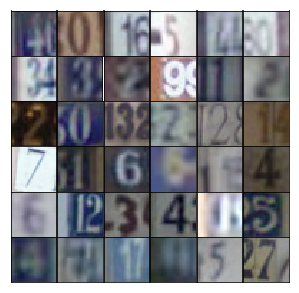

In [6]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)

fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5))

for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
plt.subplots_adjust(wspace=0, hspace=0)

# Data Preprocessing

## Scaling

In [7]:
def scale(x, feature_range=(-1, 1)):
    # np.amax()
    x = (x - x.max()) / (255. - x.min())
    
    mini, maxi = feature_range
    x = x * (maxi - mini) + mini
    
    return x

## Data Spliting and Scaling Implementation

In [8]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        # split index represents the special index after which is the validation set.
        split_idx = int(len(test['y']) * (1 - val_frac))
        
        # split train, test datasets into two parts
        # the last index of the data represents the index of the training instances.
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        # roll the index to make the first index of the data
        # the number of the instance
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        # whether to scale or not
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(self.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
            
        n_batches = len(self.train_y) // batch_size
        
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii: ii+batch_size]
            y = self.train_y[ii: ii+batch_size]
            
            yield self.scaler(x), y

# Build the Model

## Inputs

In [9]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

## Build the Generator

Upsampling, aka deconvolution or convolution tranposing, is implemented in this process, to turn a flat shape random data into a 3D data that is typical in convolutional layers.

The original __z__ is 1D, and we want an output data that is of shape of (64, 64, 3).

In [10]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # first layer
        x0 = tf.layers.dense(z, 4*4*512)
        
        # reshape x0 to start the convolutional stack
        # conv1
        x1 = tf.reshape(x0, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        # homemade leaky ReLU
        x1 = tf.maximum(alpha * x1, x1)
        # Current shape: (4, 4, 512)
        
        # conv2
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        # Current shape: (8, 8, 256)
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(x2 * alpha, x2)
        
        # conv3
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        # Current shape: (16, 16, 128)
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(x3 * alpha, x3)
        
        # output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        
        # activation
        out = tf.tanh(logits)
        
        return out

## Build the Discriminator

A typical CNN without pooling layers.

In [11]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # conv1
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(x1 * alpha, x1)
        
        # conv2
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(x2 * alpha, x2)
        
        # conv3
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(x3 * alpha, x3)
        
        # flattern
        x4 = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(x4, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

## Model Loss

Two loss should be calculator: d_loss and g_loss, representing respectively the loss of the discriminator and generator. In the former one, the loss should be calculated with respect to both the real data and the 'fake' data.

In [12]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    # g_model is also the output from the generator model.
    # This particular output is to be fed as the fake data into
    # the discriminator.
    g_model = generator(input_z, output_dim, alpha=alpha)
    
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real,
            labels=tf.ones_like(d_logits_real)
        )
    )
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.zeros_like(d_logits_fake)
        )
    )
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake,
            labels=tf.ones_like(d_logits_fake)
        )
    )
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss

## Optimizers

Two optimizers to minimize the costs of the discriminator and generator respectively.

Optimizing the loss of the discriminator is to train it to discern the real and the fake.

Optimizing the loss of the generator is to train the generator to produce fake data from the distribution which imitates the real data distribution, thus to fool the discriminator.

In [13]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    beta1 is the exponential decay for the first moment.
    see the original paper: arxiv.org/pdf/1412.6980.pdf
    """
    # get the weights and biases
    training_vars = tf.trainable_variables()
    discriminator_vars = [variable for variable in training_vars if variable.name.startswith('discriminator')]
    generator_vars = [variable for variable in training_vars if variable.name.startswith('generator')]
    
    # optimize
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        # explanation of 'var_list' in the doc:
        # var_list: Optional list or tuple of Variable objects to update to minimize loss. 
        # Defaults to the list of variables collected in the graph under the key GraphKeys.TRAINABLE_VARIABLES.
        d_train_opt = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1
        ).minimize(d_loss, var_list=discriminator_vars)
        
        g_train_opt = tf.train.AdamOptimizer(
            learning_rate=learning_rate, beta1=beta1
        ).minimize(g_loss, var_list=generator_vars)
        
    return d_train_opt, g_train_opt

## Build the Model Class

To wrap things up.

In [14]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self._input_real, self._input_z = model_inputs(real_size, z_size)
        
        self._d_loss, self._g_loss = model_loss(
            self._input_real, self._input_z, real_size[2], alpha=alpha
        )
        
        self._d_opt, self._g_opt = model_opt(
            self._d_loss, self._g_loss, learning_rate=learning_rate, beta1=beta1
        )

## Function to Display Generated Images

In [15]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, sharey=True, sharex=True)
    
    for ax, img in zip(axes.flatten(), samples[epoch]):
        # matplotlib.axes.Axes.axis??
        # 'off': Toggle axis lines and labels off
        ax.axis('off')
        # the fake image data are activated by sigmoid function,
        # which the data falls in the range [0, 1]
        # This step is to normalize it into [0, 255]
        # uint8: unsigned integer -> [0, 255]
        img = ((img - img.min()) * 255 / (img.max() - img.min())).astype(np.uint8)
        # doc:
        # https://matplotlib.org/2.0.0/api/_as_gen/matplotlib.axes.Axes.set_aspect.html
        ax.set_adjustable('box-forced') # other options: 'box', 'datalim'
        im = ax.imshow(img, aspect='equal')
    
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

# Training
## Training Function

To wrap things up in one function.

In [16]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    # we are showing 72 images every time
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))
    
    # for plotting
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                # Counting the steps
                steps += 1
                
                # Sample random noise from G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))
                
                # Optimization
                sess.run(
                    net._d_opt, # discriminator
                    feed_dict={
                        net._input_z: batch_z,
                        net._input_real: x,
                    }
                )
                sess.run(
                    net._g_opt, # generator
                    feed_dict={
                        net._input_z: batch_z,
                        net._input_real: x,
                    }
                )
                
                # print the progress
                if steps % print_every == 0:
                    train_loss_d = net._d_loss.eval(
                        {
                            net._input_z: batch_z,
                            net._input_real: x,
                        }
                    )
                    train_loss_g = net._g_loss.eval(
                        {
                            net._input_z: batch_z,
                            #net._input_real: x, # this line is muted in the original code
                        }
                    )
                    
                    print ("Epoch {:>3}/{:>3}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                    # save loss for plotting
                    losses.append((train_loss_d, train_loss_g))
                
                # periodically show sample images generated
                # by the generator function
                if steps % show_every == 0:
                    gen_samples = sess.run(
                        generator(net._input_z, 3, reuse=True, training=False),
                        feed_dict={
                            net._input_z: sample_z,
                        }
                    )
                    samples.append(gen_samples)
                    view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()
        
        saver.save(sess, './checkpoints/generator.ckpt')
    
    # pickle, aka pkl, portable serialized representations of Python objects
    with open('samples.pkl', 'wb') as f:
        # Write a pickled representation of obj to the open file object file.
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

NOTE: **GANs are sensitive to hyperparameters.**

Read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) and try experimenting with the hyperparameters.

In [17]:
dataset = Dataset(trainset, testset)

In [18]:
# real data size: SVHN image size
real_size = (32, 32, 3)

z_size = 100

# Previously:
# g_loss around 2.8417 at epoch #5
# learning_rate = 0.0002
# batch_size = 128
# epochs = 25
# alpha = 0.2
# beta1 = 0.5

# Current:
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

## Create New Model Instance and Run

In [ ]:
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

losses, samples = train(net, dataset, epochs, batch_size, figsize=(10, 5))

# Visualizing Losses

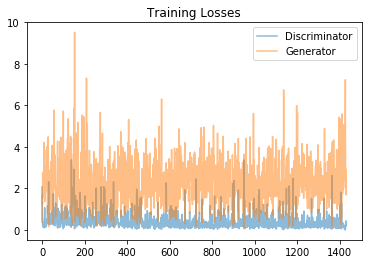

In [20]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

# Visualizing Samples

/home/ubuntu/anaconda3/envs/dlnd-tf-gpu/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


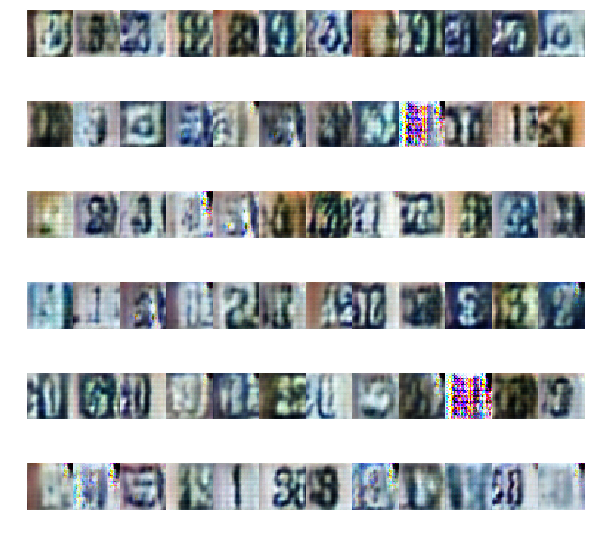

In [21]:
_ = view_samples(-1, samples, 6, 12, figsize=(10, 10))

# Summary

The fake images, though still different from the real images in human eyes, do resemble the real images, which means the generator is able to generate a artificial data distribution that is close enough to the real data distribution.

But there are some at least 5 pictures, out of the total 72 pictures, that crashed and displayed some noise, of which two are totally noise. Since the `z` input is randomly distributed between 0 and 1, these could not be a scaled problem. This would need further analysis.

## Hyper Parameters

A very small learning rate of 0.0002 is used so as to fake the details of the images.

A batch size of 128 is used rather than a larger one because we want to monitor the performance of the model, which prints out loss and displays generated images periodically.

Of course, increasing the number of epochs would definitely help, but we set it to 20 for GPU-friendly reasons. If you run this notebook on a powerful machine, it is recommended to increase the epochs to, say, 25 - 30. Also, a larger batch size would also help, when the power of computation is present.